<a href="https://colab.research.google.com/github/htdung167/CS406.M11/blob/main/Notebooks/Contour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import argparse
import cv2 as cv
import imutils

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
class DocumentScannerBasedFindContours:
  def __init__(self, image, output="type0", show_process = False):
    self.img = image
    self.output = output
    self.show_process = show_process

  def order_points(self, points):
    # print(points)
    rect = np.zeros((4,2), dtype = "float32")
    sum_ = points.sum(axis=1)
    rect[0] = points[np.argmin(sum_)]
    rect[2] = points[np.argmax(sum_)]
    diff_ = np.diff(points, axis=1)
    # print(diff_)
    rect[1] = points[np.argmin(diff_)]
    rect[3] = points[np.argmax(diff_)]
    # print(rect)
    return rect

  def transform_topdown(self, img, points):
    rect = self.order_points(points)
    tl, tr, br, bl = rect
    widthA = np.sqrt(((br[0]- bl[0])**2) +((br[1]- bl[1])**2))
    widthB = np.sqrt(((tl[0]- tr[0])**2) +((tl[1]- tr[1])**2))
    maxWidth = max(widthA, widthB)
    heightA = np.sqrt(((br[0]- tr[0])**2) +((br[1]- tr[1])**2))
    heightB = np.sqrt(((bl[0]- tl[0])**2) +((bl[1]- tl[1])**2))
    maxHeight = max(heightA, heightB)
    dst = np.array([
      [0, 0],
      [maxWidth - 1, 0],
      [maxWidth - 1, maxHeight - 1],
      [0, maxHeight - 1]], dtype = "float32")
    M = cv.getPerspectiveTransform(rect, dst)
    warped = cv.warpPerspective(img, M, (int(maxWidth), int(maxHeight)))

    # warped = cv.warpPerspective(img, M, (int(800), int(1000)))
    return warped

  def preprocess(self, blur_method="gaussian"):
    image = self.img.copy()
    self.ratio = image.shape[0] / 500.0
    self.img_resize = cv.resize(image, (int(image.shape[1] / self.ratio) ,500))
    img_gray = cv.cvtColor(self.img_resize, cv.COLOR_BGR2GRAY)
    
    img_blur = None
    if blur_method == "gaussian":
      img_blur = cv.GaussianBlur(img_gray, (3, 3), 0)
    elif blur_method == "bilateral":
      img_blur=cv.bilateralFilter(img_gray, 30, 20, 20)
    if self.show_process==True:
      cv2_imshow(self.img_resize)
      cv2_imshow(img_gray)
      cv2_imshow(img_blur)
    cv.imwrite('/content/gray.jpg', img_gray)
    cv.imwrite('/content/blur.jpg', img_blur)
    return img_blur

  def Sobel(self, img):
    Fx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]],np.float32)
    Fy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]],np.float32)
    Ix = cv.filter2D(img,-1,Fx)
    Iy = cv.filter2D(img,-1,Fy)
    G=np.hypot(Ix,Iy)
    G=G/G.max()*255
    # theta=np.arctan2(Iy,Ix)
    # return Ix,Iy,G,theta
    G = np.where(G < 50, 0, 255)
    return np.around(np.array(G).astype("uint8"))

  def handle_edge(self):
    img_blur = self.preprocess(blur_method="gaussian")
    edged = cv.Canny(img_blur, 60, 200)
    # kernel1 = np.ones((1,1), np.uint8)
    # kernel2 = np.ones((2,2), np.uint8)
    kernel3 = np.ones((3,3), np.uint8)
    # edged = self.Sobel(img_blur)
    # print(np.unique(edged))
    # edged = cv.cvtColor(edged, cv.COLOR_BGR2GRAY)


    img_close = cv.morphologyEx(edged, cv.MORPH_CLOSE, kernel3)
    if self.show_process==True:
      cv2_imshow(edged)
      cv2_imshow(img_close)
    cv.imwrite('/content/edge.jpg', edged)
    return img_close

  def calculate_area(self, points):
    area4 = 0
    fourpoints = self.order_points(points.copy())
    def dientichtamgiac(threepoints):
        A, B, C = threepoints
        area3 = 1/2 * np.abs(((B[0] - A[0])*(C[1] - A[1]) - (C[0] - A[0])*(B[1] - A[1])))
        return area3
    area4 = dientichtamgiac([points[0],points[1], points[2]]) + dientichtamgiac([points[2],points[3], points[0]])
    return area4

  def find_contours(self):
    img_close = self.handle_edge()
    cnts,_ = cv.findContours(img_close.copy(), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    # cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv.contourArea, reverse = True)[:5]
    min_area = self.img_resize.shape[0]*self.img_resize.shape[1] // 4

    self.screenCnt = None
    for c in cnts:
      perimeter = cv.arcLength(c, True)
      epsilon = perimeter*0.02
      approx = cv.approxPolyDP(c, epsilon, True)

      # print(c)

      if len(approx) == 4 and self.calculate_area(approx.reshape(4, 2)) > min_area:
        self.screenCnt = approx
        self.screenCnt = (self.screenCnt*self.ratio).astype("int32")
        break

    if self.show_process==True:
      img_cop = self.img.copy()
      cv.drawContours(img_cop, [self.screenCnt], -1, (0, 255, 0), 2)
      # print(self.screenCnt)
      for point in self.screenCnt:
        x, y = point[0]
        cv.circle(img_cop,(x, y),5,(255, 255, 127),5)
      cv2_imshow(img_cop)

  def get_result(self):
    self.find_contours()
    warped = self.transform_topdown(self.img, self.screenCnt.reshape(4, 2))
    if self.output == "type0":
      pass
    elif self.output == "type1":
      warped = cv.GaussianBlur(warped, (3,3), 0)
    elif self.output == "type2":
      warped = cv.cvtColor(warped, cv.COLOR_BGR2GRAY)
      warped = cv.adaptiveThreshold(warped, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 31, 10)
      # warped = cv.bitwise_not(warped)
      # warped = cv.morphologyEx(warped, cv.MORPH_OPEN, np.ones((3,3), np.uint8))
    self.result = warped
    if self.show_process == True:
      cv2_imshow(self.result)
    return self.img, self.result
  
  def show_result(self, smaller=100):
    origin, result = self.get_result()
    origin = cv.resize(origin, (int(origin.shape[1]*smaller/ 100), int(origin.shape[0]*smaller/ 100)))
    result = cv.resize(result, (origin.shape[1],origin.shape[0]))
    cv.imwrite('/content/result1.jpg', result)
    cv2_imshow(origin)
    cv2_imshow(result)



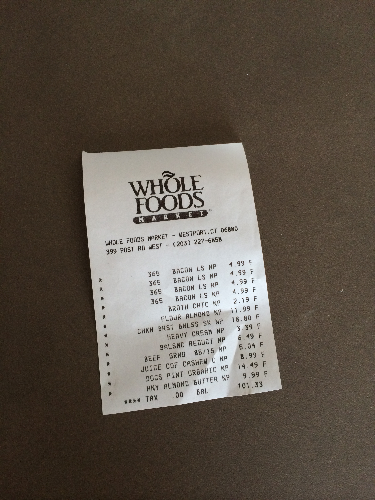

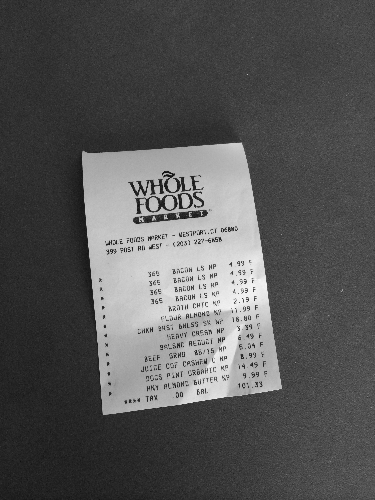

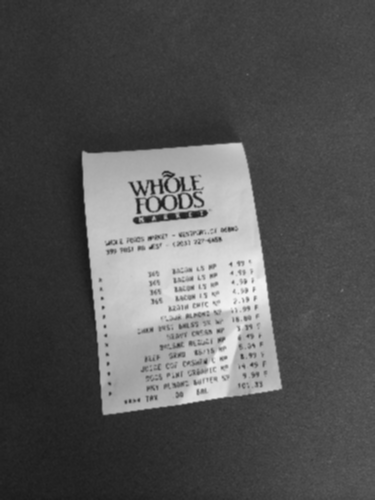

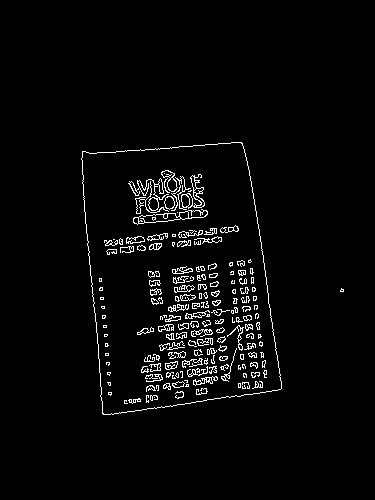

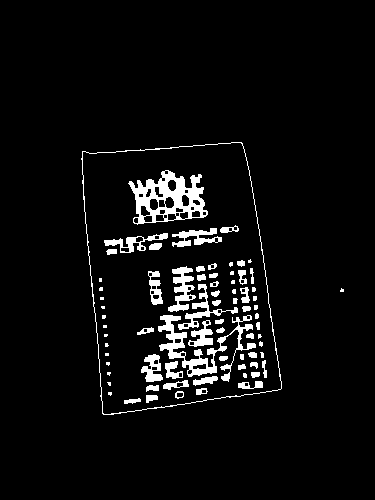

error: ignored

In [ ]:
path = "/content/drive/MyDrive/CS406 Nhóm/sample_imgs/cell_pic.jpg"
img = cv.imread(path)
scan = DocumentScannerBasedFindContours(img, "type2", True)
scan.show_result(20)